## Import libraries, define const values, and set URLs path
Set the root address (REST_API_ADDRESS) based on your docker exposed IP

In [7]:
import sys
import json
import requests
import matplotlib.pyplot as plt

# REST URL
REST_API_ADDRESS = 'http://10.90.46.32:4545/'
REST_API_ADDRESS = 'http://localhost:4545/'
Alive_URL = REST_API_ADDRESS + 'Alive'
Query_URL = REST_API_ADDRESS + 'QAL'
FlushSample_URL = REST_API_ADDRESS + 'flushsample'
RemoveTable_URL = REST_API_ADDRESS + 'removetable'
ChangeProteus_URL = REST_API_ADDRESS + 'changeProteus'
ChangeWareHouseSize_URL = REST_API_ADDRESS + 'changeWRSize'

## Check QAL is alive
Check the status of QAL

In [11]:
response = requests.get(Alive_URL)
print(response.text)


{'status':200,'message':"I am. Space quota:1000mb, Map()Map()"}


## Set Proteus credential
Set the proteus credentials. QAL needs this information to fetch tables. 

In [68]:
ProteusURL="jdbc:avatica:remote:url=http://diascld32.iccluster.epfl.ch:18007;serialization=PROTOBUF"
ProteusUsername="sdlhshah"
ProteusPassword="Shah13563556"
data={'url' : ProteusURL, 'username' : ProteusUsername, 'pass':ProteusPassword}
response = requests.get(ChangeProteus_URL,params=data)
print(response.text)

{'status':200,'message':"Proteus credential is changed."}


## Set warehouse space quota
Define size of the warehouse (in megaByte) for storing the synopses. 

In [46]:
quota=1000
data={'quota':quota}
response = requests.get(ChangeWareHouseSize_URL,params=data)
print(response.text)

{'status':200,'message':"Warehouse quota is updated."}


## Remove stored synopses
QAL stores generated synopses in the warehouse. To remove them:

In [18]:
response = requests.get(FlushSample_URL)
print(response.text)

{'status':200,'message':"Warehouse is flushed."}


## Remove downloaded tables from Proteus
QAL buffers downloaded tables from Proteus. To remove buffered tables

In [7]:
response = requests.get(RemoveTable_URL)
print(response.text)

{'status':200,'message':"Warehouse is flushed."}


## Send approximate queries via REST call
In order to check and test the QAL functionalities, we injected two test tables inside the docker image. SCT is a view made out of SpazioDati companies dataset, and PFT is a view generated from Public Funding dataset. 

## Data profile table
Data profile helps you to get information about a table. Use the keyword dataprofile instead of select and set confidence and error for your query. The result is type and range for each column of the table.

In [19]:
query="dataprofile sct confidence 80 error 10"
data = {'query':query}
response = requests.get(Query_URL, params=data)
print(response.text)

[{"name":"acheneID","type":"String","countNonNull":36260650,"countDistinct":0,"min":0.0,"max":0.0,"avg":0.0,"sum":0.0,"avgDistinct":0,"sumDistinct":0.0},
{"name":"numberOfEmployees","type":"Integer","countNonNull":17040300,"countDistinct":0,"min":0.0,"max":9352.0,"avg":3.5259426183811318,"sum":6.008312E7,"avgDistinct":6008312,"sumDistinct":6.008312E7},
{"name":"revenue","type":"Long","countNonNull":2423860,"countDistinct":0,"min":0.0,"max":2.332094E9,"avg":2202405.9145330177,"sum":5.3383236E12,"avgDistinct":2147483647,"sumDistinct":5.3383236E12},
{"name":"EBITDA","type":"Double","countNonNull":2053060,"countDistinct":0,"min":-4.2073E7,"max":1.640494E9,"avg":251561.2208118613,"sum":5.1647028E11,"avgDistinct":2147483647,"sumDistinct":5.1647028E11},
{"name":"province","type":"String","countNonNull":31670350,"countDistinct":0,"min":0.0,"max":0.0,"avg":0.0,"sum":0.0,"avgDistinct":0,"sumDistinct":0.0},
{"name":"legalStatus","type":"String","countNonNull":36260650,"countDistinct":0,"min":0.0,

In [20]:
query="dataprofile pft confidence 80 error 10"
data = {'query':query}
response = requests.get(Query_URL, params=data)
print(response.text)

[{"name":"fund","type":"String","countNonNull":2587090,"countDistinct":0,"min":0.0,"max":0.0,"avg":0.0,"sum":0.0,"avgDistinct":0,"sumDistinct":0.0},
{"name":"totalAmount","type":"Double","countNonNull":2389890,"countDistinct":0,"min":0.0,"max":1.2800325E7,"avg":15442.605940273388,"sum":3.690612951059997E10,"avgDistinct":2147483647,"sumDistinct":3.690612951059997E10},
{"name":"company_acheneID","type":"String","countNonNull":2389890,"countDistinct":0,"min":0.0,"max":0.0,"avg":0.0,"sum":0.0,"avgDistinct":0,"sumDistinct":0.0},
{"name":"legalStatus","type":"String","countNonNull":2389890,"countDistinct":0,"min":0.0,"max":0.0,"avg":0.0,"sum":0.0,"avgDistinct":0,"sumDistinct":0.0},
{"name":"grant_acheneID","type":"String","countNonNull":2389890,"countDistinct":0,"min":0.0,"max":0.0,"avg":0.0,"sum":0.0,"avgDistinct":0,"sumDistinct":0.0},
{"name":"granter_acheneID","type":"String","countNonNull":706370,"countDistinct":0,"min":0.0,"max":0.0,"avg":0.0,"sum":0.0,"avgDistinct":0,"sumDistinct":0.0}

## Get approximate quantile of numberOfEmployees and revenue of Italian companies granted public fund
This query joins two tables and calculates quantile over revenue of companies that means the result is range of buckets with equal item frequency. We are separating the data to 5 buckets.

In [14]:
query="select quantile(revenue,5) from PFT p, SCT s where p.company_acheneID= s.acheneID confidence 90 error 10"
data = {'query':query}
response = requests.get(Query_URL, params=data)
print(response.text)


[{"percent":20.0,"value":0.0},
{"percent":40.0,"value":357000.0},
{"percent":60.0,"value":1040000.0},
{"percent":80.0,"value":2453000.0}]


## -------------------------------------------------------------------------------------------------------------------------------

### Get total amount of public fund granted to Italian companies group by province
To execute the query without approximation, remove confidence and error from the statement.
Quantile and Binning cannot be executed in exact mode, do not remove confidence and error in these queries.

In [4]:
query="select count(p.totalAmount),sum(p.totalAmount),province from PFT p, SCT s where s.revenue>1000 and p.company_acheneID=s.acheneID group by s.province confidence 80 error 20"
data = {'query':query}
response = requests.get(Query_URL, params=data)
print(response.text)

[8177,6.760901655E7,Palermo]
[867,5036468.914285715,Verbano-Cusio-Ossola]
[7965,7.012070408571431E7,Firenze]
[1407,1.3724483978571424E7,Matera]
[2082,6.133944876428568E7,Trapani]
[1022,9479602.80000001,Vercelli]
[366,9297355.885714287,Vibo Valentia]
[2140,1.932791335714286E7,Barletta-Andria-Trani]
[2757,1.9123858157142855E7,Siracusa]
[4223,4.70171834357143E7,Messina]
[4840,4.1228038607142866E7,Monza e della Brianza]
[3085,2.4070558821428563E7,Taranto]
[4358,4.5509362650000006E7,Reggio nell'Emilia]
[4204,6.79380285214286E8,Ancona]
[1253,3.766330748571428E7,Nuoro]
[2507,2.2687353642857138E7,Catanzaro]
[6692,8.859520260000004E7,Modena]
[1870,1.6336325815714294E8,Livorno]
[7174,9.050080763571426E7,Bologna]
[829,1.2800552657142857E7,Isernia]
[1060,1.5644768914285712E7,Siena]
[2063,1.4818735234285718E8,Ascoli Piceno]
[19,16253.614285714284,null]
[2603,2.519028237857143E7,Pesaro e Urbino]
[2931,2.7831721114285715E7,Novara]
[4377,6.7071133542857155E7,Macerata]
[3972,3.709549035E7,Latina]
[8736


### ----------------------------------------------------------------------------------------------------------------------------------------------


### Find approximate number of wealthy companies which are granted public funds, grouped by company type (with different filters)

In [16]:
query="select count(*),s.legalStatus from PFT p, SCT s where p.company_acheneID=s.acheneID and s.revenue>100000 group by s.legalStatus confidence 80 error 10"
data = {'query':query}
response = requests.get(Query_URL, params=data)
print(response.text)

[7444,b'Societxc3xa0 Per Azioni Con Socio Unico']
[24,b'Societxc3xa0 Consortile Cooperativa A Responsabilitxc3xa0 Limitata']
[2,b'Societxc3xa0 In Accomandita Per Azioni']
[1,b'Societxc3xa0 Consortile']
[1,Soggetto Estero]
[2,Ente Sociale]
[50854,b'Societxc3xa0 Per Azioni']
[14,Consorzio Di Cui Al Dlgs 267/2000]
[1,Consorzio Intercomunale]
[55,Azienda Speciale Di Cui Al Dlgs 267/2000]
[4078,b'Societxc3xa0 Cooperativa A Responsabilita Limitata']
[51258,b'Societxc3xa0 A Responsabilitxc3xa0 Limitata Con Unico Socio']
[7,Associazione Impresa]
[3,Ente]
[33,Fondazione Impresa]
[639,b'Societxc3xa0 In Accomandita Semplice']
[365,b'Societxc3xa0 Consortile Per Azioni']
[311,b'Societxc3xa0 In Nome Collettivo']
[13,b'Societxc3xa0 Di Mutuo Soccorso']
[364,b'Societxc3xa0 Cooperativa Consortile']
[2329,b'Societxc3xa0 Consortile A Responsabilitxc3xa0 Limitata']
[1,Azienda Municipale]
[61,Azienda Speciale Di Ente Locale]
[8176,Cooperativa Sociale]
[41,b'Piccola Societxc3xa0 Cooperativa A Responsabilitxc

## Binning and visualization
You can bin a table over a attribute where you can see approximate frequency of items in each bucket. Use keyword binning(attName, start, end, bucketNumber) with desired confidence and error to get the results. 

In [15]:
query="select binning(revenue,0,100000,10) from SCT confidence 80 error 10"
data = {'query':query}
response = requests.get(Query_URL, params=data)
print(response.text)


[{"start":0.0,"end":10000.0,"count":326859},
{"start":10000.0,"end":20000.0,"count":70695},
{"start":20000.0,"end":30000.0,"count":68165},
{"start":30000.0,"end":40000.0,"count":74995},
{"start":40000.0,"end":50000.0,"count":141211},
{"start":50000.0,"end":60000.0,"count":0},
{"start":60000.0,"end":70000.0,"count":143147},
{"start":70000.0,"end":80000.0,"count":0},
{"start":80000.0,"end":90000.0,"count":141434},
{"start":90000.0,"end":100000.0,"count":70050}]


## Get approximate quantile of revenue of Italian companies

In [17]:
query="select quantile(revenue,10) from SCT s confidence 80 error 10"
data = {'query':query}
response = requests.get(Query_URL, params=data)
print(response.text)


[{"percent":10.0,"value":1.0},
{"percent":20.0,"value":1.0},
{"percent":30.0,"value":32763.0},
{"percent":40.0,"value":65535.0},
{"percent":50.0,"value":258048.0},
{"percent":60.0,"value":258048.0},
{"percent":70.0,"value":523264.0},
{"percent":80.0,"value":1048575.0},
{"percent":90.0,"value":4193791.0}]


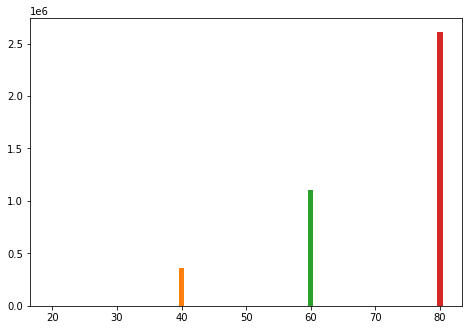

In [13]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(20,0)
ax.bar(40,365000)
ax.bar(60,1106000)
ax.bar(80,2615000)
plt.show()